In [1]:
import sys
import os
sys.path.append(os.path.abspath("../../src"))  # Adds 'src' to the module search path

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plot import plot_bar_horizontal,plot_bar_vertical,vertical_boxplot,horizontal_boxplot,create_MAD_comparison_boxplot,create_MAD_comparison_violinplot
import numpy as np
import itertools
from scipy.stats import wasserstein_distance
np.random.seed(42)
HOME_DIR = "../../"
DATASET = "../../raw_data/proteome.parquet"

# Dataset properties

## Global information

In [5]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [6]:
df[['pool','sequence']].nunique()

pool           127
sequence    291394
dtype: int64

In [7]:
len(df)

1638788

## Peptide distribution

In [9]:
df = pd.read_parquet(DATASET)

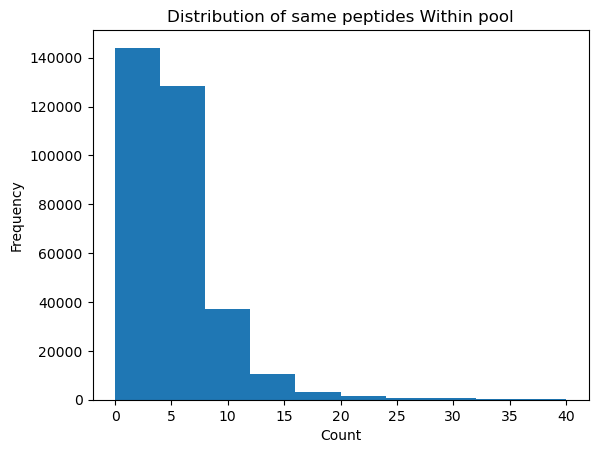

In [10]:
overlap_in_file = df.groupby(['sequence','pool'])['pool'].count()
overlap_in_file.plot.hist(range=(0, 40))
plt.title("Distribution of same peptides Within pool")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

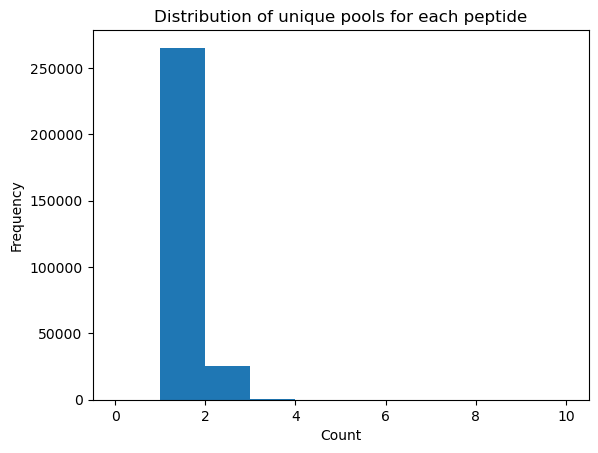

In [11]:
overlap_across_file = df.groupby('sequence')['pool'].nunique()
overlap_across_file.plot.hist(range=(0, 10))
plt.title("Distribution of unique pools for each peptide")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

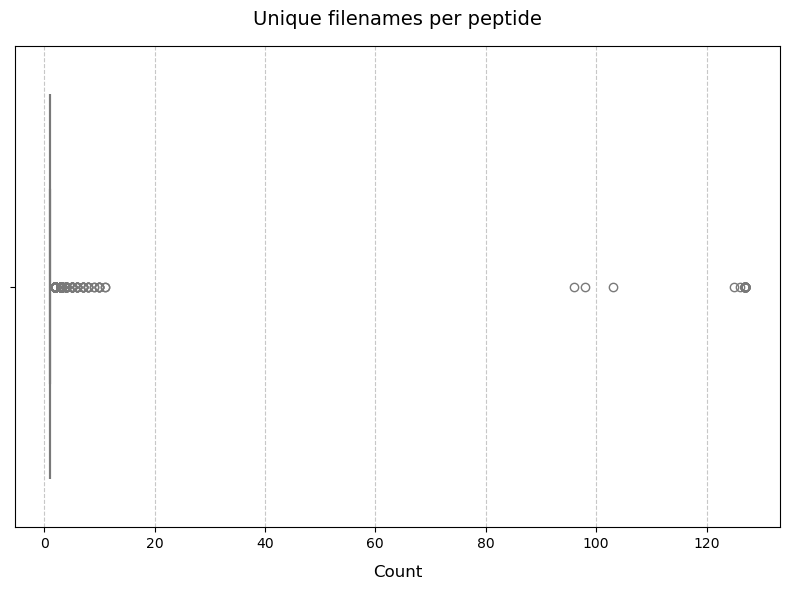

In [12]:
horizontal_boxplot(overlap_across_file,"Count","Unique filenames per peptide",show_fliers=True)

# Retention time analysis

In [14]:
df = pd.read_parquet(DATASET)

## MAD

In [16]:
def median_absolute_deviation(series, threshold=None):
    if threshold is not None and len(series) < threshold:
        return None
    
    # Convert to numpy array if it's not already
    if isinstance(series, pd.Series):
        data = series.values
    else:
        data = np.asarray(series)
    
    # Calculate the median
    median_value = np.median(data)
    
    # Calculate the absolute deviations from the median
    abs_deviations = np.abs(data - median_value)
    
    # Calculate the median of the absolute deviations
    mad = np.median(abs_deviations)
    
    return mad

In [17]:
median_same_msrun = df.groupby(['sequence', 'pool'])['iRT'].apply(lambda x: median_absolute_deviation(x, 2)).dropna()
median_across_all = df.groupby(['sequence'])['iRT'].apply(lambda x: median_absolute_deviation(x, 2)).dropna()

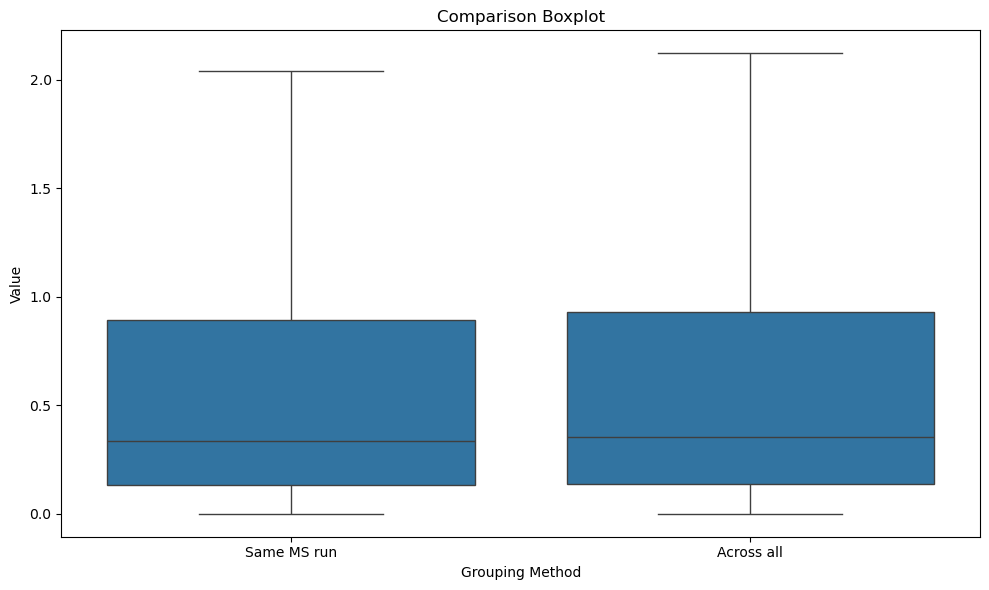

In [18]:
create_MAD_comparison_boxplot([median_same_msrun,median_across_all],["Same MS run","Across all"])

C:\Users\lambe\Documents\School\thesis\MTL-peptide-property-prediction_temp\src\plot.py:186: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='MAD', y='Group', data=df_violin, cut=0, ax=ax,


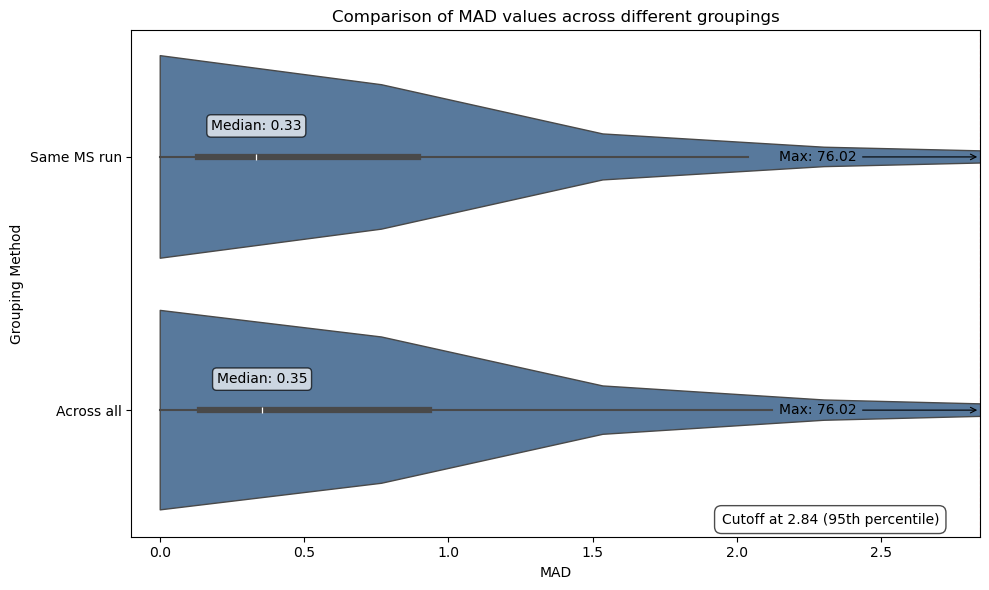

In [19]:
create_MAD_comparison_violinplot([median_same_msrun,median_across_all],["Same MS run","Across all"])

C:\Users\lambe\Documents\School\thesis\MTL-peptide-property-prediction_temp\src\plot.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


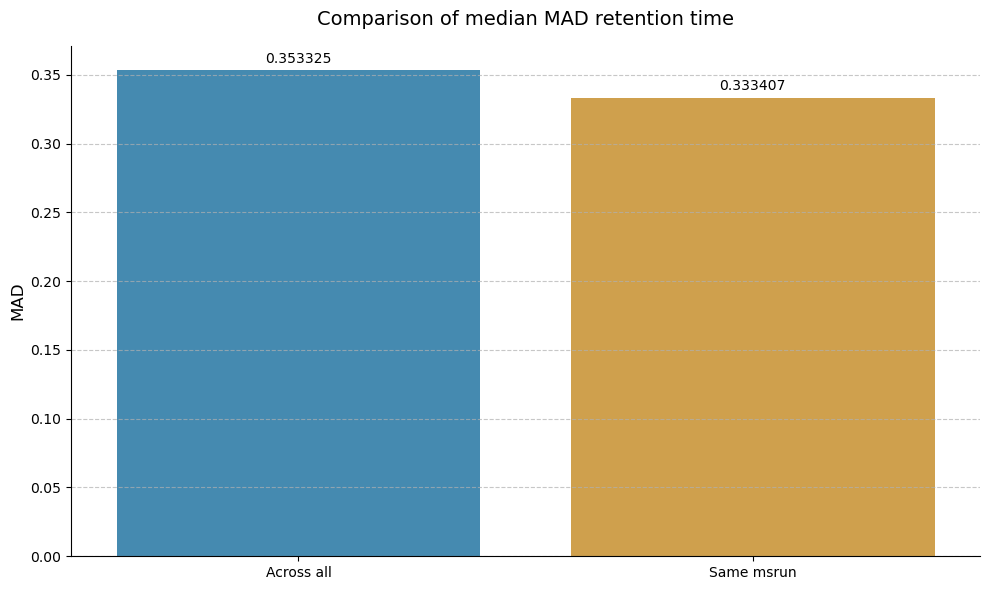

In [20]:
comparison = pd.Series(
    [median_same_msrun.median(),median_across_all.median()],
    index=["Same msrun","Across all"]
)
# Call the plotting function with the Series
plot_bar_vertical(
    data_series=comparison,
    title="Comparison of median MAD retention time",
    xlabel="",
    ylabel="MAD",
    figsize=(10, 6)
)

## KDE plots

In [22]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [23]:
def plot_kde_grouped(df, threshold, legend=None):
    grouped = df.groupby('sequence')
    for sequence, seq_group in grouped:
        plt.figure(figsize=(8, 6))
        # Group again within each sequence by filename to get iRT values
        for filename, values in seq_group.groupby('pool')['iRT']:
            values = list(values)  # Convert Series to list
            if len(values) >= threshold:
                label = f"{filename} (n={len(values)})"
                sns.kdeplot(values, label=label, fill=False)

        plt.xlabel("Retention Time")
        plt.ylabel("Density")
        if legend:
            plt.legend(title="Filename", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f"KDE Plot for Sequence: {sequence}")
        plt.show()

In [24]:
overlap_across_msrun = df.groupby('sequence')['pool'].nunique()
overlap_in_msrun = df.groupby(['sequence','pool'])['pool'].count()

In [25]:
interesting_peptides_across = overlap_across_msrun[(overlap_across_msrun > 10)].index
# Filter rows where the value is > 5
filtered = overlap_in_msrun[overlap_in_msrun > 5]

# Group by sequence and find sequences appearing more than 5 times
sequence_counts = filtered.groupby('sequence').count()
interesting_peptides_inside = sequence_counts[sequence_counts > 5].index
interesting_peptides = interesting_peptides_across.intersection(interesting_peptides_inside)[:10]

In [26]:
df_sequence = df[df['sequence'].isin(interesting_peptides)]

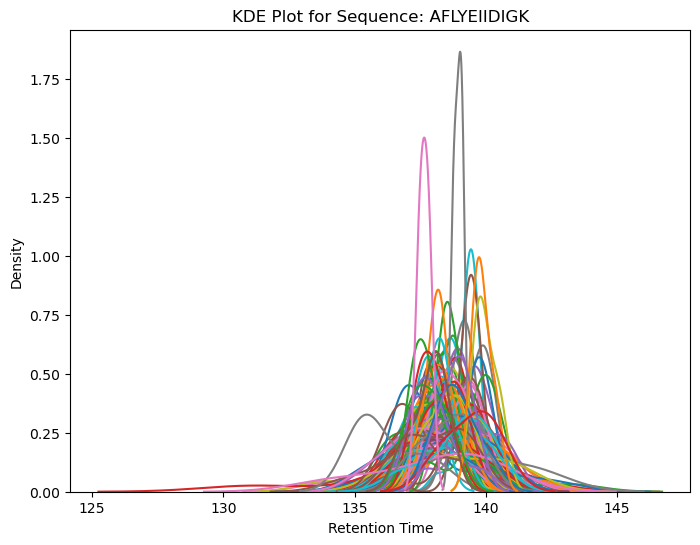

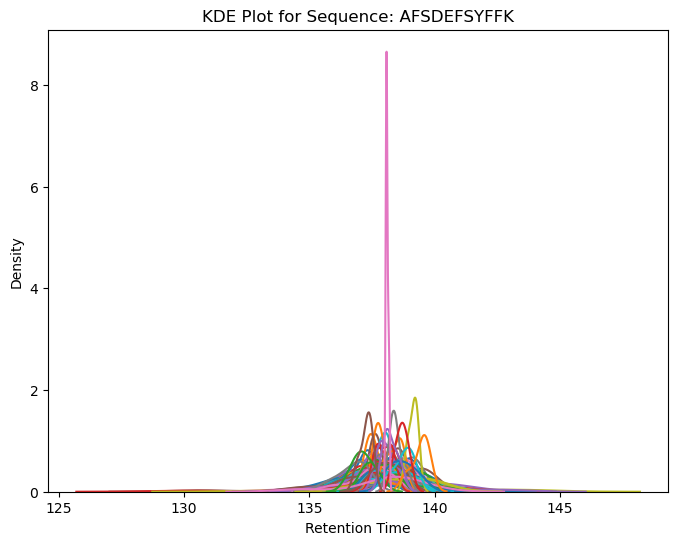

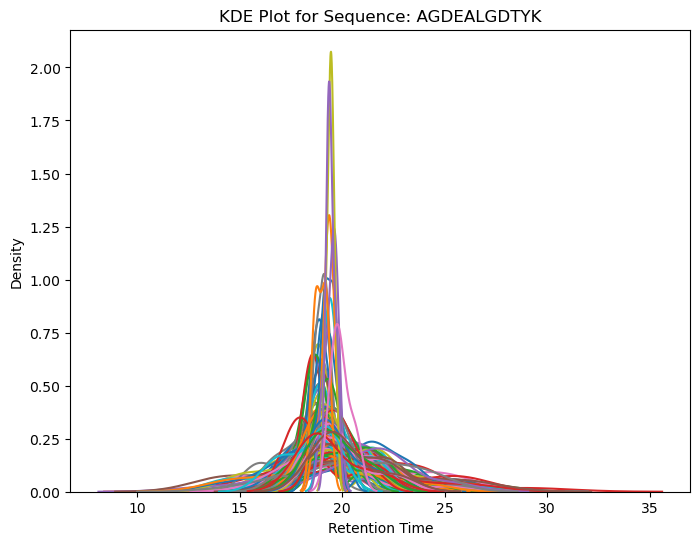

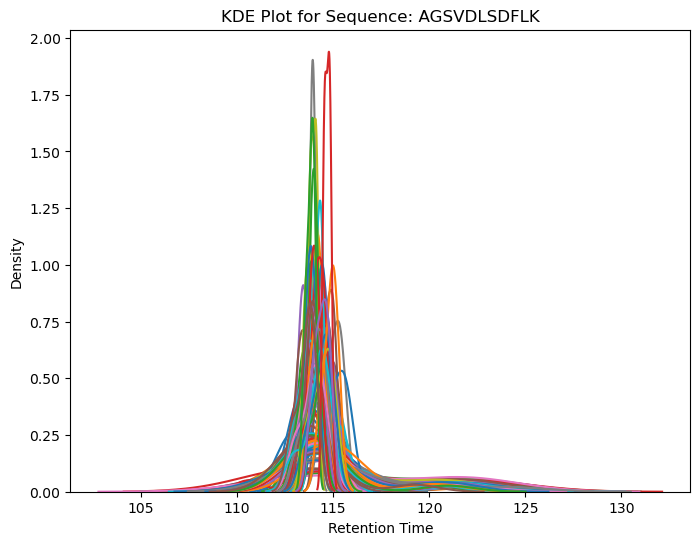

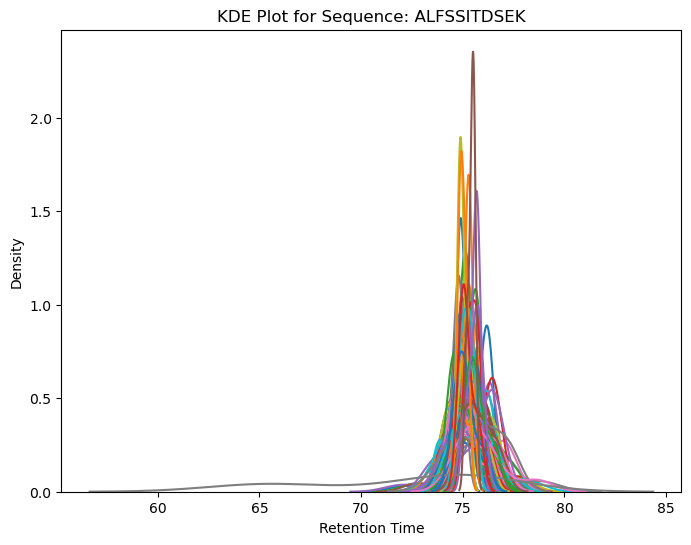

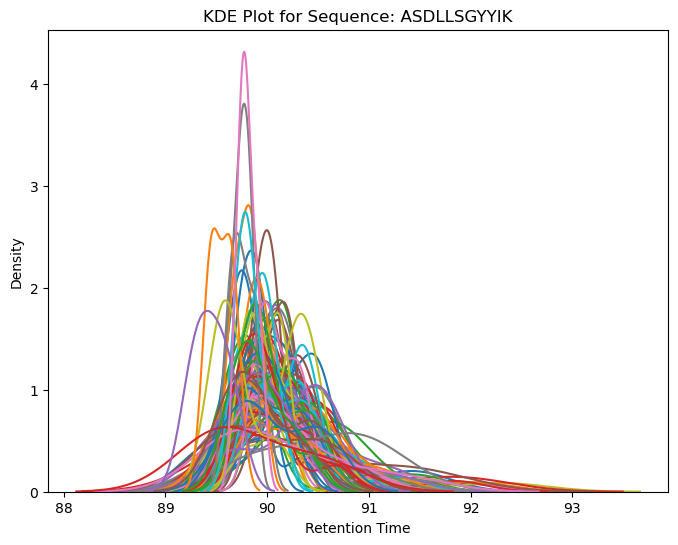

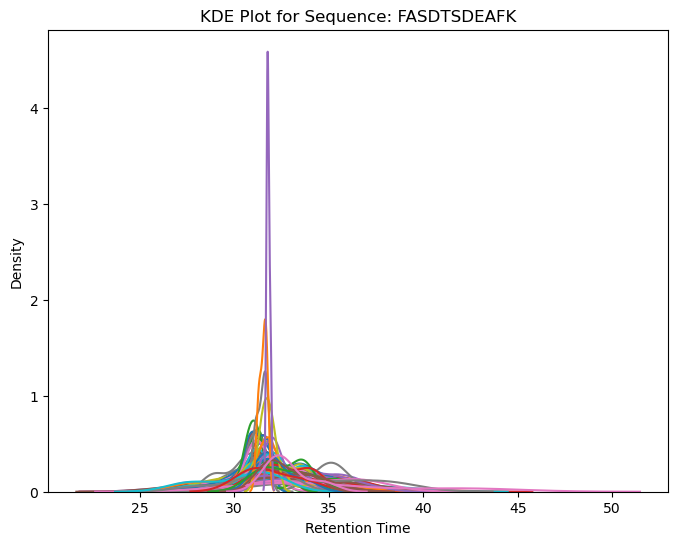

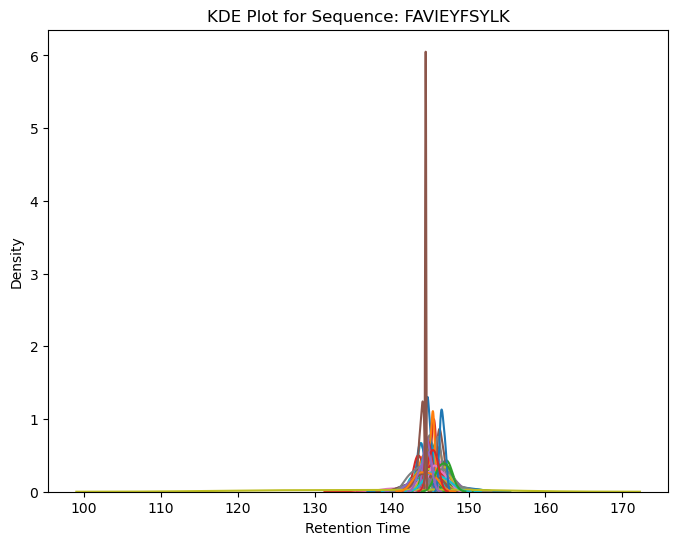

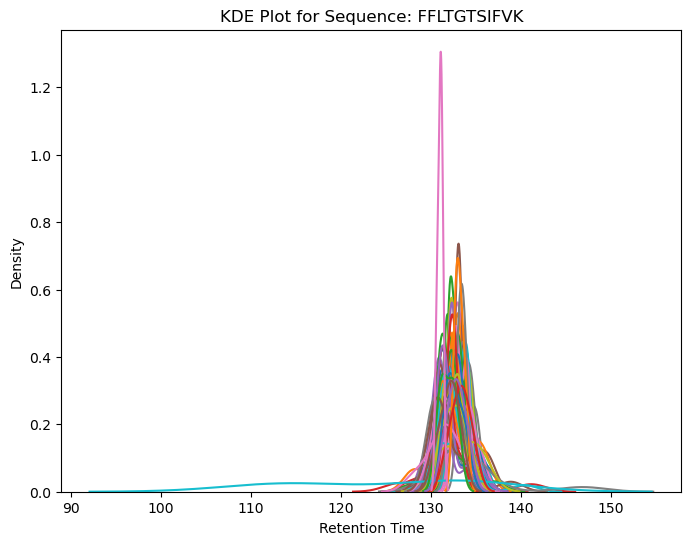

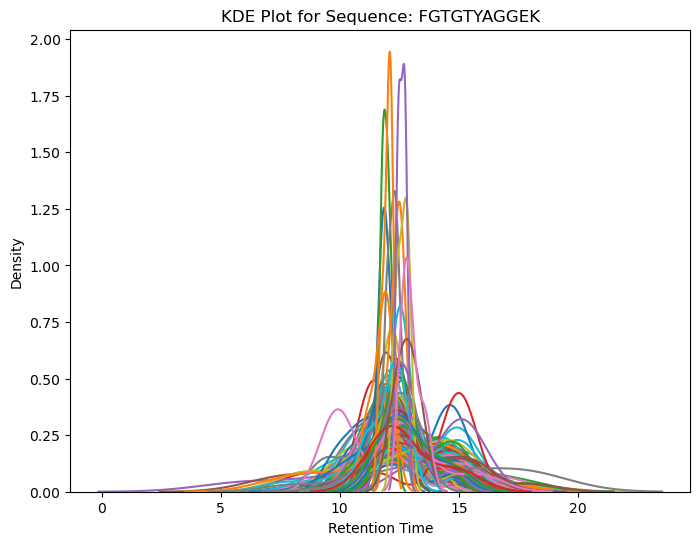

In [27]:
plot_kde_grouped(df_sequence,2)

## Wasserstein distance

In [29]:
df = pd.read_parquet(DATASET)

In [30]:
def compute_mean_wasserstein_distance(df,min_files):
    grouped = df.groupby('sequence')
    mean_distances = {}

    for sequence, group in grouped:
        distributions = group.groupby('pool')['iRT'].apply(list)
        distributions_dict = {k: v for k, v in distributions.to_dict().items() if len(v) >= min_files}  # Exclude single-value distributions
        filenames = list(distributions_dict.keys())

        distances = [
            wasserstein_distance(distributions_dict[file1], distributions_dict[file2])
            for file1, file2 in itertools.combinations(filenames, 2)
        ]

        if distances:
            mean_distances[sequence] = sum(distances) / len(distances)

    return mean_distances

In [31]:
mean_wasserstein = compute_mean_wasserstein_distance(df,1)

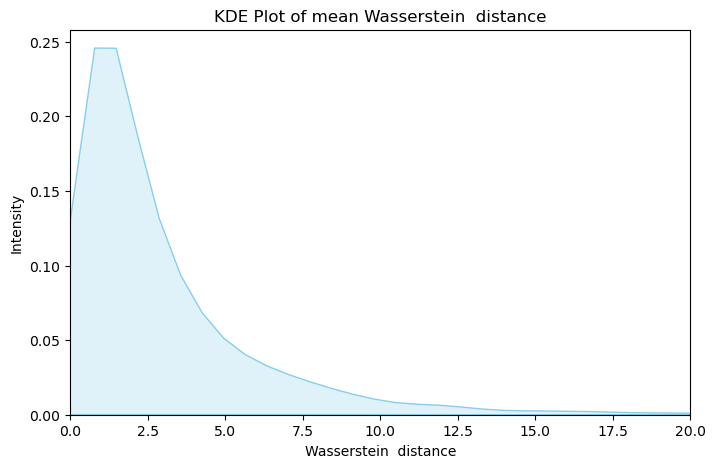

In [32]:
# Extract values
x_values = np.array(list(mean_wasserstein.values()))

# Create KDE plot
plt.figure(figsize=(8, 5))
sns.kdeplot(x_values, fill=True, color="skyblue")
plt.xlim(0, 20)

# Labels and title
plt.xlabel("Wasserstein  distance")
plt.ylabel("Intensity")
plt.title("KDE Plot of mean Wasserstein  distance")

# Show the plot
plt.show()